# improve_data_label_v21

v20: v19(로더/체크포인트 안정화) + **좌표 초기화/출력 경로 수정**으로 예측 붕괴(선분/클러스터) 문제를 해결한 버전.

- 핵심 수정: EGNN 내부 좌표 `x`를 0으로 시작하지 않고, **학습 가능한 init_x(h)** 로 초기화 → 좌표 업데이트가 실제로 동작
- 출력: `preds = x + head_offset(h)` 구조로 v12 스타일 복원 (멀티헤드 유지)


## v15 변경점 (v14 대비 예측 붕괴/좌표 업데이트 무력화 해결)

1) **좌표 초기화(degenerate zero-init) 제거**
- v13/v14는 `x=0`에서 시작해 `dx = (xi-xj)*w` 이라서 **항상 dx=0 → x가 영원히 0** 문제가 생길 수 있음
- v15는 `x = init_x(h)` 로 시작해 **rij가 0이 아니게 만들고**, EGNN의 좌표 업데이트가 실제로 동작

2) **출력 경로 수정**
- `preds = x + offset_k(h)` 형태로, EGNN이 만든 기하 정보를 출력에 직접 반영

3) 나머지(로더/체크포인트/학습루프)는 v14 그대로


In [1]:
# ==========================================
# 0) Imports, Device, Config  [v21]
#   목표: v19에서 보였던 '중심 근처로 뭉치는(모드 붕괴)' 현상 완화
#   핵심 변경:
#     1) 멀티스케일(디레이티드) + base-pair 게이트 long-edge 추가 → 장거리 정보 전달 강화
#     2) warmup을 '절대좌표 L1' 대신 'edge distance' 기반으로 변경(회전/이동 불변) → 학습 일관성 ↑
#     3) softmin에 epsilon-mix를 넣어 모든 head가 항상 일정량의 gradient를 받도록 함 → dead head 방지
# ==========================================
import os, math, random
from dataclasses import dataclass
from typing import Optional, Any, Dict, Tuple, List

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

@dataclass
class CFG:
    seed: int = 42

    # data
    max_len: int = 256
    min_valid: int = 10
    batch: int = 8
    num_workers: int = 0          # 안전 기본값 (Windows/Jupyter hang 방지)
    loader_timeout: int = 60      # num_workers>0 일 때만 사용

    # model
    vocab: int = 5  # PAD=0, A=1,C=2,G=3,U=4
    d_model: int = 192
    d_edge: int = 256
    n_layers: int = 8

    # local seq edges
    k_nn: int = 12  # local neighborhood radius = k_nn//2

    # long-range / multi-scale edges (dilated)
    long_dilations: Tuple[int, ...] = (8, 16, 32, 64, 128)
    long_edge_gate_power: float = 1.0   # long-edge gate: pij**power

    # K heads
    num_preds: int = 4
    dropout: float = 0.1

    # coord init / update
    chain_init_scale: float = 0.15   # deterministic chain prior scale (breaks near-zero rij deadzone)
    init_x_scale: float = 1.0        # learnable init_x(h) scale
    offset_scale: float = 0.1        # head offset scale(초기 안정화)
    coord_step_scale: float = 0.10   # EGNN 좌표 업데이트 스텝
    recenter_each_layer: bool = True # translation drift 억제(안정화)

    # base-pair feature
    bp_tau: float = 40.0
    bp_min_sep: int = 4
    pair_alpha: float = 2.0

    # optimization
    lr: float = 2e-4
    weight_decay: float = 0.02
    epochs: int = 20
    warmup_epochs: int = 1           # v20: warmup은 edge-distance 기반(회전/이동 불변)
    grad_clip: float = 1.0

    # mixed precision / stability
    amp: bool = False
    loss_fp32: bool = True
    fail_on_nan: bool = True

    # softmin aggregation
    softmin_temp: float = 1.0
    softmin_eps: float = 0.05        # ✅ v20: 모든 head에 최소 gradient 보장

    # losses
    use_confidence: bool = True
    conf_w: float = 0.05

    # structured loss weights
    edge_dist_w: float = 0.35        # ✅ v21: edge-distance loss 강화        # ✅ v20: graph-edge distance loss (핵심)
    dist_w: float = 0.30             # ✅ v21: sampled distance-matrix loss ON (국소 왜곡 억제)             # (선택) 랜덤 pair distance loss (v19) - 기본 off
    pair_num_pairs: int = 2048       # ✅ v21: pair 샘플 수 증가
    aux_every: int = 1

    # (옵션) best-k 분석용 혼합 기준 (RMSD + alpha*dist)
    bestk_alpha: float = 0.30

    local_w: float = 0.2
    var_w: float = 0.02
    repulse_w: float = 0.02
    diversity_w: float = 0.01
    repulse_margin: float = 2.5
    diversity_margin: float = 2.0

    # checkpoint / resume
    ckpt_dir: str = "checkpoints"
    ckpt_stage1_path: str = "checkpoints/best_stage1_v20.pt"
    ckpt_best_path: str = "checkpoints/best_structured_v20.pt"
    resume_path: str = ""
    patience: int = 10

    # debug
    profile_first_batch: bool = True

cfg = CFG()
os.makedirs(cfg.ckpt_dir, exist_ok=True)
seed_everything(cfg.seed)

# (선택) matmul 정밀도 힌트 (Ampere+에서 유효)
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass


device: cuda


## 1) Dataset / Data Loading

In [2]:

# ==========================================
# 1) Load CSVs
# ==========================================
train_seq = pd.read_csv("train_sequences.csv")
val_seq   = pd.read_csv("validation_sequences.csv")

train_labels = pd.read_csv("train_labels.csv")
val_labels   = pd.read_csv("validation_labels.csv")

print("train_seq:", train_seq.shape, "val_seq:", val_seq.shape)
print("train_labels:", train_labels.shape, "val_labels:", val_labels.shape)

# ==========================================
# 2) Tokenize sequences (A,C,G,U -> 1..4, PAD=0)
# ==========================================
mapping = {'A': 1, 'C': 2, 'G': 3, 'U': 4}

def tokenize_sequence(seq: str):
    # unknown -> 0 (PAD)
    return [mapping.get(ch, 0) for ch in seq]

train_seq['tokens'] = train_seq['sequence'].astype(str).apply(tokenize_sequence)
val_seq['tokens']   = val_seq['sequence'].astype(str).apply(tokenize_sequence)

print(train_seq[['target_id','sequence']].head())
# ==========================================
# 3) Build coordinates + coord_mask from labels
# ==========================================
XYZ = ['x_1','y_1','z_1']
THRESH = 1e4  # v16: float16 overflow/이상치 방지용 상한

def _make_target_id_and_resid(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['target_id'] = df['ID'].astype(str).str.rsplit('_', n=1).str[0]
    df['resid'] = pd.to_numeric(df['resid'], errors='coerce')
    df = df.dropna(subset=['resid']).copy()
    df['resid'] = df['resid'].astype(int)
    df = df.sort_values(['target_id','resid'])
    return df

def build_coords_from_train_labels(train_labels: pd.DataFrame) -> pd.DataFrame:
    df = _make_target_id_and_resid(train_labels)
    for c in XYZ:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    arr = df[XYZ].to_numpy(dtype=np.float64)
    ok = np.isfinite(arr).all(axis=1) & (np.abs(arr) < THRESH).all(axis=1)
    df['coord_ok'] = ok.astype(np.float32)
    df.loc[~ok, XYZ] = 0.0
    df[XYZ] = df[XYZ].astype(np.float32)

    coords_df = (df.groupby('target_id')[XYZ]
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coordinates'))
    mask_df   = (df.groupby('target_id')['coord_ok']
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coord_mask'))
    return coords_df.merge(mask_df, on='target_id', how='inner')

def build_coords_from_val_labels(val_labels: pd.DataFrame, K: int = 40) -> pd.DataFrame:
    df = _make_target_id_and_resid(val_labels)

    chosen = np.zeros((len(df), 3), dtype=np.float32)
    ok_mask = np.zeros((len(df),), dtype=np.float32)
    filled = np.zeros((len(df),), dtype=bool)

    for k in range(1, K+1):
        cols = [f'x_{k}', f'y_{k}', f'z_{k}']
        if not all(c in df.columns for c in cols):
            continue
        tmp = df[cols].apply(pd.to_numeric, errors='coerce')
        arr = tmp.to_numpy(dtype=np.float64)
        ok = np.isfinite(arr).all(axis=1) & (np.abs(arr) < THRESH).all(axis=1)
        take = ok & (~filled)
        if take.any():
            chosen[take] = arr[take].astype(np.float32)
            ok_mask[take] = 1.0
            filled[take] = True

    df['x_1'] = chosen[:,0]
    df['y_1'] = chosen[:,1]
    df['z_1'] = chosen[:,2]
    df['coord_ok'] = ok_mask

    coords_df = (df.groupby('target_id')[XYZ]
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coordinates'))
    mask_df   = (df.groupby('target_id')['coord_ok']
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coord_mask'))
    return coords_df.merge(mask_df, on='target_id', how='inner')

train_coords = build_coords_from_train_labels(train_labels)
val_coords   = build_coords_from_val_labels(val_labels, K=40)

train_coords['target_id'] = train_coords['target_id'].astype(str).str.strip()
val_coords['target_id']   = val_coords['target_id'].astype(str).str.strip()

print("train_coords:", train_coords.shape)
print("val_coords  :", val_coords.shape)

def has_nan_inf(coords):
    a = np.asarray(coords, dtype=np.float32)
    return (not np.isfinite(a).all())

print("train_coords NaN/Inf:", train_coords['coordinates'].apply(has_nan_inf).sum())
print("val_coords   NaN/Inf:", val_coords['coordinates'].apply(has_nan_inf).sum())


def has_bad_mask(m):
    a = np.asarray(m, dtype=np.float32)
    if (not np.isfinite(a).all()):
        return True
    # allow only 0/1 (float)
    return bool(((a != 0.0) & (a != 1.0)).any())

def max_abs_valid(coords, mask):
    c = np.asarray(coords, dtype=np.float32)
    m = np.asarray(mask, dtype=np.float32).astype(bool)
    if m.sum() == 0:
        return 0.0
    return float(np.abs(c[m]).max())

print("train_coords bad mask:", train_coords['coord_mask'].apply(has_bad_mask).sum())
print("val_coords   bad mask:", val_coords['coord_mask'].apply(has_bad_mask).sum())

# 좌표 범위 체크(유효 마스크 기준)
_tc = train_coords.sample(n=min(len(train_coords), 500), random_state=0) if len(train_coords)>500 else train_coords
print("train_coords max|coord| (valid only, sample<=500):",
      _tc.apply(lambda r: max_abs_valid(r['coordinates'], r['coord_mask']), axis=1).max())
_vc = val_coords.sample(n=min(len(val_coords), 500), random_state=0) if len(val_coords)>500 else val_coords
print("val_coords   max|coord| (valid only, sample<=500):",
      _vc.apply(lambda r: max_abs_valid(r['coordinates'], r['coord_mask']), axis=1).max())


C:\Users\tkdwl\AppData\Local\Temp\ipykernel_21864\1999568070.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  train_labels = pd.read_csv("train_labels.csv")


train_seq: (5716, 8) val_seq: (28, 8)
train_labels: (7794971, 8) val_labels: (9762, 126)
  target_id                                           sequence
0      4TNA  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
1      6TNA  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
2      1TRA  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
3      1TN2  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
4      1TN1  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
train_coords: (5716, 3)
val_coords  : (28, 3)
train_coords NaN/Inf: 0
val_coords   NaN/Inf: 0
train_coords bad mask: 0
val_coords   bad mask: 0
train_coords max|coord| (valid only, sample<=500): 778.1259765625
val_coords   max|coord| (valid only, sample<=500): 420.6499938964844


In [3]:
# ==========================================
# 4) Build unified dataframe: sequences + coords
# ==========================================
all_seq = pd.concat([train_seq, val_seq], ignore_index=True)
all_coords = pd.concat([train_coords, val_coords], ignore_index=True)

all_seq['target_id'] = all_seq['target_id'].astype(str).str.strip()
all_coords['target_id'] = all_coords['target_id'].astype(str).str.strip()

all_df = all_seq.merge(all_coords, on='target_id', how='inner')

# keep only rows that have at least a few valid coordinates
def count_valid(m): 
    m = np.asarray(m, dtype=np.float32)
    return float(m.sum())

all_df['n_valid'] = all_df['coord_mask'].apply(count_valid)
all_df = all_df[all_df['n_valid'] >= cfg.min_valid].reset_index(drop=True)

print("all_df:", all_df.shape)
print(all_df[['target_id','n_valid']].head())


# ==========================================
# 5) Dataset (centering only; NO target-based RMS scaling)
# ==========================================
class RNADataset(Dataset):
    def __init__(self, tokens_list, coords_list, mask_list, max_len=256, center_only=True):
        self.tokens_list = tokens_list
        self.coords_list = coords_list
        self.mask_list = mask_list
        self.max_len = max_len
        self.center_only = center_only

    def __len__(self):
        return len(self.tokens_list)

    
    def __getitem__(self, idx):
        # 직접 참조 (복사 최소화)
        tokens = self.tokens_list[idx]
        coords = self.coords_list[idx]
        mask   = self.mask_list[idx]

        # numpy 변환 (필요 시 1회만)
        if not isinstance(tokens, np.ndarray):
            tokens = np.array(tokens, dtype=np.int64)
        if not isinstance(coords, np.ndarray):
            coords = np.array(coords, dtype=np.float32)
        if not isinstance(mask, np.ndarray):
            mask = np.array(mask, dtype=np.float32)

        L = min(len(tokens), len(coords), len(mask), self.max_len)

        tokens = tokens[:L]
        coords = coords[:L]
        mask   = mask[:L]

        # ✅ NaN/Inf 방지: mask/coords sanitize + mask 0/1 강제
        mask = np.nan_to_num(mask, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
        mask = (mask > 0.5).astype(np.float32)
        mask_bool = mask.astype(bool)
        coords = coords.astype(np.float32)

        if self.center_only:
            finite_row = np.isfinite(coords).all(axis=1)
            center_idx = mask_bool & finite_row
            if center_idx.any():
                coords = coords - coords[center_idx].mean(axis=0, keepdims=True)

        # invalid(or missing) coords는 0으로 강제 (loss에서 무시되지만, 디버그/수치안정에 유리)
        coords = np.nan_to_num(coords, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
        coords[~mask_bool] = 0.0
        # padding (vectorized, 최소 연산)
        tokens_p = np.zeros(self.max_len, dtype=np.int64)
        coords_p = np.zeros((self.max_len, 3), dtype=np.float32)
        mask_p   = np.zeros(self.max_len, dtype=np.float32)

        tokens_p[:L] = tokens
        coords_p[:L] = coords
        mask_p[:L]   = mask

        # torch.from_numpy (복사 없음 → 매우 빠름)
        return (
            torch.from_numpy(tokens_p),
            torch.from_numpy(coords_p),
            torch.from_numpy(mask_p),
        )

def filter_batch(tokens, target, mask, min_valid):
    # drop samples with too few valid coords (training stability)
    keep = (mask.sum(dim=1) >= min_valid)
    if keep.sum() < 2:
        return None
    return tokens[keep], target[keep], mask[keep]


# ==========================================
# 6) Train/Holdout split + DataLoader  [v13.2 speed]
# ==========================================
idx_train, idx_hold = train_test_split(range(len(all_df)), test_size=0.1, random_state=cfg.seed)

train_df = all_df.iloc[idx_train].reset_index(drop=True)
hold_df  = all_df.iloc[idx_hold].reset_index(drop=True)

train_ds = RNADataset(train_df['tokens'].tolist(),
                      train_df['coordinates'].tolist(),
                      train_df['coord_mask'].tolist(),
                      max_len=cfg.max_len,
                      center_only=True)

hold_ds  = RNADataset(hold_df['tokens'].tolist(),
                      hold_df['coordinates'].tolist(),
                      hold_df['coord_mask'].tolist(),
                      max_len=cfg.max_len,
                      center_only=True)

dl_num_workers = int(getattr(cfg, "num_workers", 0) or 0)

# NOTE (Windows/Jupyter): num_workers>0가 멈춘 것처럼 보이는 경우가 많습니다.
# v14 기본값은 0이며, 속도가 필요하면 2→4로 천천히 올려가며 확인하세요.
if os.name == "nt":
    dl_num_workers = 0

# ✅ 중요: PyTorch는 num_workers==0 인데 timeout>0이면 AssertionError가 날 수 있습니다.
timeout = int(getattr(cfg, "loader_timeout", 0) or 0) if (dl_num_workers > 0) else 0

dl_kwargs = dict(
    num_workers=dl_num_workers,
    pin_memory=(device.type == "cuda"),
)
if dl_num_workers > 0:
    dl_kwargs.update(dict(persistent_workers=True, prefetch_factor=2))

train_loader = DataLoader(
    train_ds,
    batch_size=cfg.batch,
    shuffle=True,
    timeout=timeout,
    **dl_kwargs
)
hold_loader = DataLoader(
    hold_ds,
    batch_size=cfg.batch,
    shuffle=False,
    timeout=timeout,
    **dl_kwargs
)

print("train batches:", len(train_loader), "hold batches:", len(hold_loader))

# ---- First-batch sanity check (detect loader hangs / preprocessing stalls) ----
import time as _time
_t0 = _time.time()
try:
    _it = iter(train_loader)
    _b = next(_it)
    print(f"[loader precheck] first batch OK in {_time.time()-_t0:.2f}s")
    # print shapes
    if isinstance(_b, (tuple, list)):
        print("[loader precheck] batch shapes:", [getattr(x, "shape", type(x)) for x in _b])
except Exception as e:
    print("[loader precheck] FAILED:", repr(e))
    raise



all_df: (5739, 12)
  target_id  n_valid
0      4TNA     76.0
1      6TNA     76.0
2      1TRA     76.0
3      1TN2     76.0
4      1TN1     76.0
train batches: 646 hold batches: 72
[loader precheck] first batch OK in 0.10s
[loader precheck] batch shapes: [torch.Size([8, 256]), torch.Size([8, 256, 3]), torch.Size([8, 256])]


## 2) Base-pair feature 주입

In [4]:

# ==========================================
# 2) Base-pair probability encoder (sequence-only heuristic)
#   - 입력 tokens(B,T) -> p(B,T,T) in [0,1]
#   - canonical: A-U, C-G, G-U wobble
#   - 거리 prior: exp(-|i-j|/tau), and |i-j|>=bp_min_sep
# ==========================================
class BasePairEncoder(nn.Module):
    def __init__(self, tau: float = 40.0, min_sep: int = 4):
        super().__init__()
        self.tau = float(tau)
        self.min_sep = int(min_sep)

        # 0 PAD, 1 A,2 C,3 G,4 U
        # canonical probs
        P = torch.zeros((5,5), dtype=torch.float32)
        P[1,4] = 1.0; P[4,1] = 1.0  # A-U
        P[2,3] = 1.0; P[3,2] = 1.0  # C-G
        P[3,4] = 0.6; P[4,3] = 0.6  # G-U wobble (weaker)
        self.register_buffer("pair_table", P, persistent=False)

    def forward(self, tokens: torch.Tensor, pad_mask: Optional[torch.Tensor] = None):
        """
        tokens: (B,T) int64
        pad_mask: (B,T) True for valid nodes (optional)
        returns p: (B,T,T) float32
        """
        B, T = tokens.shape
        t_i = tokens[:, :, None]  # (B,T,1)
        t_j = tokens[:, None, :]  # (B,1,T)

        base = self.pair_table[t_i, t_j]  # (B,T,T)

        # 거리 prior
        idx = torch.arange(T, device=tokens.device)
        dist = (idx[None, :, None] - idx[None, None, :]).abs().float()  # (1,T,T)
        sep_ok = (dist >= float(self.min_sep)).float()
        prior = torch.exp(-dist / max(self.tau, 1e-6)) * sep_ok

        p = base * prior  # (B,T,T)

        if pad_mask is not None:
            m = pad_mask.float()
            p = p * (m[:, :, None] * m[:, None, :])

        # zero diagonal
        p = p * (1.0 - torch.eye(T, device=p.device, dtype=p.dtype)[None, :, :])
        return p


## 3) Loss helpers (Kabsch + sampled distance + local/var)

In [5]:
# ==========================================
# 3) Loss utilities  [v16 NaN-safe]
#   - mask 곱셈(0)과 inf의 조합(inf*0=nan) 방지: masked_fill/where 방식
#   - softmin에서 inf/NaN sanitize
#   - Kabsch는 FP32에서 수행
# ==========================================
def _sanitize_losses(x: torch.Tensor, large: float = 1e6) -> torch.Tensor:
    # nan/inf -> 큰 유한값으로 치환 (softmin/가중합에서 0*inf -> nan 방지)
    return torch.nan_to_num(x, nan=large, posinf=large, neginf=large)

def softmin_weights(losses: torch.Tensor, temperature: float = 1.0, eps: float = 0.0) -> torch.Tensor:
    """losses: (B,K) -> weights (B,K)
    eps>0이면 w = (1-eps)*softmin + eps/K 로 섞어서 dead head를 방지.
    """
    temp = max(float(temperature), 1e-8)
    L = _sanitize_losses(losses.float())
    w = torch.softmax(-L / temp, dim=1)
    if eps is not None and float(eps) > 0:
        K = w.size(1)
        w = (1.0 - float(eps)) * w + float(eps) * (1.0 / float(K))
        w = w / (w.sum(dim=1, keepdim=True) + 1e-12)
    return w

def softmin_aggregate(losses: torch.Tensor, temperature: float = 1.0, eps: float = 0.0) -> torch.Tensor:
    """losses: (B,K) -> scalar"""
    L = _sanitize_losses(losses.float())
    w = softmin_weights(L, temperature, eps=eps)
    return (w * L).sum(dim=1).mean()

def masked_l1_losses(preds: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """Return per-head masked L1: (B,K)"""
    # preds: (B,K,T,3)
    B, K, T, _ = preds.shape
    m = mask.bool()  # (B,T)
    m3 = m.unsqueeze(-1)  # (B,T,1)

    denom = (m.sum(dim=1).float() * 3.0).clamp_min(1.0)  # (B,)
    out = []
    for k in range(K):
        pk = preds[:, k].float()
        tg = target.float()
        # invalid positions are force-set to 0 without multiplication (inf*0 회피)
        pk = pk.masked_fill(~m3, 0.0)
        tg = tg.masked_fill(~m3, 0.0)
        diff = (pk - tg).abs()
        l1 = diff.sum(dim=(1, 2)) / denom
        out.append(l1)
    return _sanitize_losses(torch.stack(out, dim=1))

def kabsch_align(P: torch.Tensor, Q: torch.Tensor, mask: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """Align P to Q using Kabsch. SVD always runs in FP32.
    ✅ v18 NaN fix: (1) regularize H with eps*I before SVD to prevent degenerate
       singular values; (2) nan_to_num guard on the output.
    """
    with torch.amp.autocast(device_type=('cuda' if P.is_cuda else 'cpu'), enabled=False):
        P32 = P.float()
        Q32 = Q.float()
        m32 = mask.float().unsqueeze(-1)  # (B,T,1)

        msum = m32.sum(dim=1, keepdim=True).clamp_min(eps)
        P_mean = (P32 * m32).sum(dim=1, keepdim=True) / msum
        Q_mean = (Q32 * m32).sum(dim=1, keepdim=True) / msum

        P_c = (P32 - P_mean) * m32
        Q_c = (Q32 - Q_mean) * m32

        H = torch.matmul(P_c.transpose(1, 2), Q_c).contiguous()  # (B,3,3)
        # ✅ Tikhonov regularization: prevent degenerate H (all-zero or rank<3)
        #    which causes NaN gradients through SVD.
        H = H + eps * torch.eye(3, device=H.device, dtype=H.dtype).unsqueeze(0)

        U, S, Vh = torch.linalg.svd(H, full_matrices=False)
        V = Vh.transpose(1, 2)

        det = torch.det(torch.matmul(V, U.transpose(1, 2)))
        sign = torch.where(det < 0, -torch.ones_like(det), torch.ones_like(det))

        E = torch.eye(3, device=H.device, dtype=H.dtype).unsqueeze(0).repeat(H.shape[0], 1, 1)
        E[:, 2, 2] = sign
        R = torch.matmul(torch.matmul(V, E), U.transpose(1, 2))  # (B,3,3)

        P_aligned = torch.matmul(P_c, R.transpose(1, 2)) + Q_mean
        P_aligned = P_aligned * m32
        # ✅ guard: SVD may still produce NaN if H is pathological; replace with 0
        P_aligned = torch.nan_to_num(P_aligned, nan=0.0, posinf=0.0, neginf=0.0)

    return P_aligned.to(dtype=P.dtype)

def kabsch_rmsd_losses(preds: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """Per-head RMSD after Kabsch alignment: (B,K)"""
    B, K, T, _ = preds.shape
    m = mask.bool()
    m3 = m.unsqueeze(-1)
    denom = (m.sum(dim=1).float() * 3.0).clamp_min(1.0)  # (B,)
    out = []
    for k in range(K):
        pk = preds[:, k]
        pk_aligned = kabsch_align(pk, target, mask)
        # invalid positions -> 0으로 강제
        pa = pk_aligned.float().masked_fill(~m3, 0.0)
        tg = target.float().masked_fill(~m3, 0.0)
        diff_sq = (pa - tg) ** 2
        sum_sq = diff_sq.sum(dim=(1, 2))  # (B,)
        # ✅ v18: clamp sum_sq to >=0 before sqrt (floating point can give tiny negatives)
        rmsd = torch.sqrt((sum_sq / denom).clamp_min(0.0) + 1e-8)
        out.append(rmsd)
    return _sanitize_losses(torch.stack(out, dim=1))

def pairwise_distance_losses_sampled(preds: torch.Tensor, target: torch.Tensor, mask: torch.Tensor, num_pairs: int = 2048) -> torch.Tensor:
    """Per-head sampled pairwise distance MSE: (B,K)"""
    B, K, T, _ = preds.shape
    device_ = preds.device
    preds_f = preds.float()
    target_f = target.float()

    losses_bk = torch.zeros((B, K), device=device_, dtype=torch.float32)
    valid_indices = [torch.where(mask[b].bool())[0] for b in range(B)]

    for b in range(B):
        idx = valid_indices[b]
        n = idx.numel()
        if n < 2:
            continue

        i = idx[torch.randint(0, n, (num_pairs,), device=device_)]
        j = idx[torch.randint(0, n, (num_pairs,), device=device_)]

        tgt_d = (target_f[b, i] - target_f[b, j]).norm(dim=-1)  # (num_pairs,)

        for k in range(K):
            pk = preds_f[b, k]
            pred_d = (pk[i] - pk[j]).norm(dim=-1)
            losses_bk[b, k] = ((pred_d - tgt_d) ** 2).mean()

    return _sanitize_losses(losses_bk)

def coord_variance_losses(preds: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """Per-head masked coordinate variance (B,K). Larger is better (anti-collapse)."""
    B, K, T, _ = preds.shape
    m = mask.bool()
    m3 = m.unsqueeze(-1)

    denom = m.sum(dim=1).float().clamp_min(1.0)  # (B,)
    out = []
    for k in range(K):
        pk = preds[:, k].float()
        pk = pk.masked_fill(~m3, 0.0)
        mean = pk.sum(dim=1, keepdim=True) / denom.view(B, 1, 1)
        var = ((pk - mean) ** 2).sum(dim=(1, 2)) / (denom * 3.0)
        out.append(var)
    return _sanitize_losses(torch.stack(out, dim=1))

def local_bond_losses(preds: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """Per-head adjacent (i,i+1) bond length MSE: (B,K)."""
    B, K, T, _ = preds.shape
    m = mask.bool()
    m_adj = (m[:, 1:] & m[:, :-1])  # (B,T-1)

    preds_f = preds.float()
    target_f = target.float()

    tgt = (target_f[:, 1:] - target_f[:, :-1]).norm(dim=-1)  # (B,T-1)
    denom = m_adj.sum(dim=1).float().clamp_min(1.0)  # (B,)

    out = []
    for k in range(K):
        pk = preds_f[:, k]
        pd = (pk[:, 1:] - pk[:, :-1]).norm(dim=-1)
        diff = (pd - tgt) ** 2
        diff = diff.masked_fill(~m_adj, 0.0)
        l = diff.sum(dim=1) / denom
        out.append(l)
    return _sanitize_losses(torch.stack(out, dim=1))

def edge_distance_losses(preds: torch.Tensor, target: torch.Tensor, mask: torch.Tensor,
                         edge_index: torch.Tensor) -> torch.Tensor:
    """Per-head edge distance MSE on given graph edges: (B,K)
    edge_index: (2,E) indices in [0,T)
    """
    B, K, T, _ = preds.shape
    src, dst = edge_index[0], edge_index[1]
    m = mask.bool()
    evalid = (m[:, src] & m[:, dst])  # (B,E)
    denom = evalid.sum(dim=1).float().clamp_min(1.0)  # (B,)

    tgt_d = (target.float()[:, src] - target.float()[:, dst]).norm(dim=-1)  # (B,E)

    out = []
    preds_f = preds.float()
    for k in range(K):
        pk = preds_f[:, k]
        pd = (pk[:, src] - pk[:, dst]).norm(dim=-1)
        diff = (pd - tgt_d) ** 2
        diff = diff.masked_fill(~evalid, 0.0)
        l = diff.sum(dim=1) / denom
        out.append(l)
    return _sanitize_losses(torch.stack(out, dim=1))

def kabsch_rmsd_metric_min(preds, target, mask) -> torch.Tensor:
    with torch.no_grad():
        rmsd_bk = kabsch_rmsd_losses(preds, target, mask)  # (B,K)
        return rmsd_bk.min(dim=1).values.mean()

# ------------------------------------------
# TM-score metric (competition-aligned: best-of-K, index-matched residues)
# d0 follows the RNA Folding Kaggle metric (Ribonanza TM-score) piecewise form.
# ------------------------------------------
def _tm_d0(L: int) -> float:
    if L < 12: return 0.3
    if L < 15: return 0.4
    if L < 18: return 0.5
    if L < 21: return 0.6
    if L < 30: return 0.7
    return max(0.6 * math.sqrt(L - 0.5) - 2.5, 0.5)

def tm_score_single(pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    pred_aligned = kabsch_align(pred, target, mask)
    d = (pred_aligned.float() - target.float()).norm(dim=-1)  # (B,T)
    m = mask.bool()
    tm_list = []
    for b in range(pred.shape[0]):
        idx = m[b]
        L = int(idx.sum().item())
        if L <= 0:
            tm_list.append(pred.new_tensor(0.0, dtype=torch.float32))
            continue
        d0 = _tm_d0(L)
        db = d[b, idx]
        tm = (1.0 / (1.0 + (db / d0) ** 2)).mean()
        tm_list.append(tm)
    return torch.stack(tm_list, dim=0)

def tm_score_metric_maxK(preds: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        B, K, T, _ = preds.shape
        tms = []
        for k in range(K):
            tm_k = tm_score_single(preds[:, k], target, mask)  # (B,)
            tms.append(tm_k)
        tms = torch.stack(tms, dim=1)  # (B,K)
        return tms.max(dim=1).values.mean()


In [6]:
# ==========================================
# v11 추가: non-neighbor repulsion + head diversity  [v16 NaN-safe]
# ==========================================
def repulsion_losses_sampled(preds: torch.Tensor, mask: torch.Tensor,
                             num_pairs: int = 2048, margin: float = 2.5) -> torch.Tensor:
    """겹침 방지용 hinge loss. 인접(i,i+1)은 제외하고 랜덤 pair에 대해
    d < margin 이면 (margin-d)^2 를 부과.
    returns (B,K)
    """
    B, K, T, _ = preds.shape
    device_ = preds.device
    preds_f = preds.float()
    losses = torch.zeros((B, K), device=device_, dtype=torch.float32)
    valid_indices = [torch.where(mask[b].bool())[0] for b in range(B)]

    for b in range(B):
        idx = valid_indices[b]
        n = idx.numel()
        if n < 3:
            continue

        i = idx[torch.randint(0, n, (num_pairs,), device=device_)]
        j = idx[torch.randint(0, n, (num_pairs,), device=device_)]

        nn_mask = (torch.abs(i - j) > 1)
        if nn_mask.sum() < 8:
            continue
        i = i[nn_mask]
        j = j[nn_mask]

        for k in range(K):
            pk = preds_f[b, k]
            d = (pk[i] - pk[j]).norm(dim=-1)
            hinge = (margin - d).clamp_min(0.0)
            losses[b, k] = (hinge * hinge).mean()

    return _sanitize_losses(losses)

def head_diversity_losses(preds: torch.Tensor, mask: torch.Tensor, margin: float = 2.0) -> torch.Tensor:
    """헤드 간 유사하면 패널티. (B,K)로 반환해서 기존 softmin 프레임에 맞춘다.
    각 헤드의 masked centered coords를 만들고, 헤드쌍 RMSD가 margin보다 작으면 hinge.
    """
    B, K, T, _ = preds.shape
    preds_f = preds.float()
    m = mask.bool()
    m3 = m.unsqueeze(-1)
    denom = m.sum(dim=1).float().clamp_min(1.0)  # (B,)

    # centered (invalid는 0)
    centered = preds_f.masked_fill(~m3.unsqueeze(1), 0.0)
    mean = centered.sum(dim=2, keepdim=True) / denom.view(B, 1, 1, 1)
    centered = centered - mean
    centered = centered.masked_fill(~m3.unsqueeze(1), 0.0)

    out = torch.zeros((B, K), device=preds.device, dtype=torch.float32)
    if K < 2:
        return out

    for a in range(K):
        pen = 0.0
        cnt = 0
        for b in range(K):
            if a == b:
                continue
            diff = (centered[:, a] - centered[:, b]) ** 2  # (B,T,3)
            # invalid는 0으로 masked_fill (inf*0 방지)
            diff = diff.masked_fill(~m3, 0.0)
            rmsd = torch.sqrt(diff.sum(dim=(1, 2)) / (denom * 3.0) + 1e-8)  # (B,)
            hinge = (margin - rmsd).clamp_min(0.0)
            pen = pen + hinge * hinge
            cnt += 1
        out[:, a] = pen / max(cnt, 1)

    return _sanitize_losses(out)


## 4) Model (Pair-aware EGNN)

In [7]:
# ==========================================
# 4) Model (EGNN backbone + Pair-aware message passing + K coord heads + ConfidenceHead)  [v19]
#   - pad edge masking: (pad->valid) ghost message 제거
#   - coord update 안정화: tanh + coord_step_scale
#   - v15: init_x(h) + preds = x + offset_k(h)
# ==========================================
class PositionalEncodingLearned(nn.Module):
    def __init__(self, d_model: int, max_len: int = 2048):
        super().__init__()
        self.pe = nn.Embedding(max_len, d_model)
        nn.init.normal_(self.pe.weight, mean=0.0, std=0.02)

    def forward(self, x):
        T = x.size(1)
        pos = torch.arange(T, device=x.device)
        return x + self.pe(pos)[None, :, :]

def build_multiscale_edges(T: int, k_local: int, dilations: Tuple[int, ...], device):
    """멀티스케일(로컬 + 디레이티드) edge 생성.
    - 로컬: |i-j| <= r (r=k_local//2)
    - 롱: i<->i+d for d in dilations
    반환:
      edge_index: (2,E)
      edge_long : (E,) float {0,1}  (1이면 long edge)
    """
    r = max(1, int(k_local) // 2)
    edges = set()
    long_edges = set()

    # local edges
    for i in range(T):
        for j in range(max(0, i - r), min(T, i + r + 1)):
            if i == j:
                continue
            edges.add((i, j))

    # dilated long edges
    for d in list(dilations):
        d = int(d)
        if d <= 0:
            continue
        for i in range(T):
            j = i + d
            if j < T:
                edges.add((i, j)); edges.add((j, i))
                long_edges.add((i, j)); long_edges.add((j, i))

    # materialize
    src = [e[0] for e in edges]
    dst = [e[1] for e in edges]
    edge_index = torch.tensor([src, dst], dtype=torch.long, device=device)
    edge_long = torch.tensor([1.0 if (e in long_edges) else 0.0 for e in edges],
                             dtype=torch.float32, device=device)
    return edge_index, edge_long


class EGNNPairAwareLayer(nn.Module):
    """
    EGNN + pair feature p_ij (base-pair 확률)
    message: phi(h_i, h_j, d_ij^2, p_ij)
    + long-range boost: (1 + pair_alpha * p_ij) 를 coord/node 업데이트에 곱한다.
    """
    def __init__(self, d_node: int, d_edge: int, dropout: float, pair_alpha: float = 2.0, coord_scale: float = 0.10, gate_power: float = 1.0):
        super().__init__()
        self.pair_alpha = float(pair_alpha)
        self.coord_scale = float(coord_scale)
        self.gate_power = float(gate_power)

        self.edge_mlp = nn.Sequential(
            nn.Linear(d_node*2 + 1 + 1, d_edge),  # +p_ij
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(d_edge, d_edge),
            nn.SiLU(),
        )
        self.coord_mlp = nn.Sequential(
            nn.Linear(d_edge, d_edge),
            nn.SiLU(),
            nn.Linear(d_edge, 1),
        )
        self.node_mlp = nn.Sequential(
            nn.Linear(d_node + d_edge, d_node),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(d_node, d_node),
        )
        self.ln = nn.LayerNorm(d_node)

    def forward(self, h, x, edge_index, edge_long, node_mask, pair_p):
        """
        h: (B,T,D), x: (B,T,3)
        edge_index: (2,E)
        node_mask: (B,T) bool
        pair_p: (B,T,T) float in [0,1]
        """
        B, T, D = h.shape
        src, dst = edge_index[0], edge_index[1]  # (E,)

        hi = h[:, src, :]
        hj = h[:, dst, :]
        xi = x[:, src, :]
        xj = x[:, dst, :]

        rij = xi - xj
        dij2 = (rij * rij).sum(dim=-1, keepdim=True)  # (B,E,1)
        pij = pair_p[:, src, dst].unsqueeze(-1)        # (B,E,1)

        # ✅ edge mask: pad 노드가 섞인 edge는 완전히 제거(ghost message 방지)
        if node_mask is not None:
            evalid = (node_mask[:, src] & node_mask[:, dst]).float().unsqueeze(-1)  # (B,E,1)
        else:
            evalid = 1.0

        m_ij = self.edge_mlp(torch.cat([hi, hj, dij2, pij], dim=-1))  # (B,E,d_edge)
        m_ij = m_ij * evalid

        boost = (1.0 + self.pair_alpha * pij).clamp(0.0, 10.0) * evalid

        # ✅ v20: long-edge는 base-pair 확률(pij)로 게이트 (pij가 낮으면 거의 0)
        if edge_long is not None:
            el = edge_long.view(1, -1, 1).to(dtype=boost.dtype)
            gate = (1.0 - el) + el * (pij.clamp(0.0, 1.0) ** self.gate_power)
            boost = boost * gate

        # ✅ coord update 안정화: tanh로 제한 + step scale
        w = torch.tanh(self.coord_mlp(m_ij)) * (self.coord_scale) * boost  # (B,E,1)
        dx = rij * w  # (B,E,3)

        agg_dx = x.new_zeros((B, T, 3))
        agg_m  = h.new_zeros((B, T, m_ij.size(-1)))

        # aggregate to src node
        agg_dx.index_add_(1, src, dx.to(agg_dx.dtype))
        agg_m.index_add_(1, src, (m_ij * boost).to(agg_m.dtype))

        if node_mask is not None:
            agg_dx = agg_dx.masked_fill(~node_mask[:, :, None], 0.0)
            agg_m  = agg_m.masked_fill(~node_mask[:, :, None], 0.0)

        # ✅ v19: coord 폭발 방지 clamp (coord_step_scale 이후에도 누적될 수 있음)
        agg_dx = agg_dx.clamp(-5.0, 5.0)
        x = x + agg_dx
        h = self.ln(h + self.node_mlp(torch.cat([h, agg_m], dim=-1)))

        if node_mask is not None:
            h = h.masked_fill(~node_mask[:, :, None], 0.0)
            x = x.masked_fill(~node_mask[:, :, None], 0.0)
        return h, x

class ConfidenceHead(nn.Module):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(cfg.d_model, cfg.d_model//2),
            nn.GELU(),
            nn.Dropout(cfg.dropout),
            nn.Linear(cfg.d_model//2, cfg.num_preds)
        )

    def forward(self, h, pad_mask):
        if pad_mask is None:
            pooled = h.mean(dim=1)
        else:
            m = pad_mask.float().unsqueeze(-1)
            denom = m.sum(dim=1).clamp_min(1.0)
            pooled = (h * m).sum(dim=1) / denom
        out = self.mlp(pooled)  # (B,K)
        # ✅ v19: AMP FP16에서 overflow → NaN/Inf 방지
        out = torch.nan_to_num(out.float(), nan=0.0, posinf=20.0, neginf=-20.0).clamp(-30.0, 30.0)
        return out

class EGNNv20(nn.Module):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.cfg = cfg
        self.embed = nn.Embedding(cfg.vocab, cfg.d_model, padding_idx=0)
        self.posenc = PositionalEncodingLearned(cfg.d_model, max_len=cfg.max_len)
        self.bp_enc = BasePairEncoder(tau=cfg.bp_tau, min_sep=cfg.bp_min_sep)

        # precompute multiscale edges for max_len (CPU에 저장 후 forward에서 device로 이동)
        ei, el = build_multiscale_edges(cfg.max_len, cfg.k_nn, cfg.long_dilations, device=torch.device('cpu'))
        self.register_buffer('edge_index_base', ei, persistent=False)
        self.register_buffer('edge_long_base', el, persistent=False)

        self.layers = nn.ModuleList([
            EGNNPairAwareLayer(cfg.d_model, cfg.d_edge, cfg.dropout,
                               pair_alpha=cfg.pair_alpha,
                               coord_scale=float(getattr(cfg, "coord_step_scale", 0.10)),
                               gate_power=float(getattr(cfg, "long_edge_gate_power", 1.0)))
            for _ in range(cfg.n_layers)
        ])

        # ✅ v15: learnable coord init (breaks zero-symmetry)
        self.init_x = nn.Linear(cfg.d_model, 3)
        self.init_scale = float(getattr(cfg, "init_x_scale", 1.0))

        # ✅ v15: K-head offsets (v12 style)
        self.offset = nn.Sequential(
            nn.Linear(cfg.d_model, cfg.d_model),
            nn.SiLU(),
            nn.Linear(cfg.d_model, cfg.num_preds * 3),
        )
        self.offset_scale = float(getattr(cfg, "offset_scale", 0.1))

        self.conf_head = ConfidenceHead(cfg)

        # init
        nn.init.normal_(self.init_x.weight, mean=0.0, std=0.02)
        nn.init.zeros_(self.init_x.bias)

    def forward(self, tokens, pad_mask=None):
        """
        tokens: (B,T)
        pad_mask: (B,T) bool (True for valid nodes)
        returns:
          preds: (B,K,T,3)
          conf_logits: (B,K)
        """
        B, T = tokens.shape
        if pad_mask is None:
            pad_mask = (tokens != 0)

        h = self.embed(tokens)
        h = self.posenc(h)
        h = h.masked_fill(~pad_mask[:, :, None], 0.0)

        # ---- initialize coords (deterministic chain prior + learnable init_x(h)) ----
        pos = torch.arange(T, device=tokens.device, dtype=torch.float32)
        chain = torch.stack([pos, torch.zeros_like(pos), torch.zeros_like(pos)], dim=-1)  # (T,3)
        chain = chain - chain.mean(dim=0, keepdim=True)
        chain = chain * float(getattr(self.cfg, 'chain_init_scale', 0.15))
        x = chain.unsqueeze(0).repeat(B, 1, 1)
        x = x + self.init_x(h) * self.init_scale  # (B,T,3)
        x = x.masked_fill(~pad_mask[:, :, None], 0.0)

        # center x to remove translation (stabilizes warmup L1; target is centered in dataset)
        m = pad_mask.float().unsqueeze(-1)
        denom = m.sum(dim=1, keepdim=True).clamp_min(1.0)
        x = x - (x * m).sum(dim=1, keepdim=True) / denom
        x = x.masked_fill(~pad_mask[:, :, None], 0.0)

        edge_index = self.edge_index_base.to(tokens.device)
        edge_long  = self.edge_long_base.to(tokens.device)

        # pair probabilities (sequence-only heuristic)
        pair_p = self.bp_enc(tokens, pad_mask)  # (B,T,T)

        for layer in self.layers:
            h, x = layer(h, x, edge_index, edge_long, pad_mask, pair_p)
            # ✅ v20: translation drift 억제(선택)
            if bool(getattr(self.cfg, 'recenter_each_layer', False)):
                m = pad_mask.float().unsqueeze(-1)
                denom = m.sum(dim=1, keepdim=True).clamp_min(1.0)
                x = x - (x * m).sum(dim=1, keepdim=True) / denom
                x = x.masked_fill(~pad_mask[:, :, None], 0.0)
        # K-head offsets
        off = self.offset(h).view(B, T, self.cfg.num_preds, 3) * self.offset_scale  # (B,T,K,3)
        off = off.permute(0, 2, 1, 3).contiguous()  # (B,K,T,3)

        preds = x.unsqueeze(1) + off  # (B,K,T,3)
        preds = preds.masked_fill(~pad_mask[:, None, :, None], 0.0)
        # ✅ v19: EGNN 누적 폭발 방지 (agg_dx index_add_ overflow)
        preds = torch.nan_to_num(preds, nan=0.0, posinf=1e4, neginf=-1e4)
        preds = preds.clamp(-1e4, 1e4)

        conf_logits = self.conf_head(h, pad_mask)  # (B,K)
        return preds, conf_logits


## 5) LossComposer (weak distance auxiliary 포함)

In [8]:
# ==========================================
# 5) LossComposer  [v20]
#   - warmup: edge-distance 기반(회전/이동 불변) → 절대좌표 L1로 인한 '평균(0)으로 수렴' 문제 완화
#   - main: Kabsch RMSD + edge-distance + local + (repulsion/variance/diversity) + confidence(optional)
#   - softmin: epsilon-mix로 모든 head가 항상 gradient를 받도록 함(죽은 head 방지)
# ==========================================
class LossComposer(nn.Module):
    def __init__(self, cfg, edge_index: Optional[torch.Tensor] = None):
        super().__init__()
        self.cfg = cfg
        self.edge_index = edge_index  # (2,E) on some device
        self.kl = nn.KLDivLoss(reduction='batchmean')

    def forward(self, preds, target, mask, epoch, step: int = 0, conf_logits=None):
        temp = float(self.cfg.softmin_temp)
        eps  = float(getattr(self.cfg, "softmin_eps", 0.0))
        device_type = ('cuda' if preds.is_cuda else 'cpu')

        # ✅ loss는 FP32에서 계산
        if bool(getattr(self.cfg, "loss_fp32", True)):
            with torch.amp.autocast(device_type=device_type, enabled=False):
                preds_f = preds.float()
                target_f = target.float()
                mask_f   = mask.float()
                conf_f   = conf_logits.float() if conf_logits is not None else None
                return self._forward_impl(preds_f, target_f, mask_f, epoch, step, conf_f, temp, eps)
        else:
            return self._forward_impl(preds, target, mask, epoch, step, conf_logits, temp, eps)

    def _get_edge_index(self, preds: torch.Tensor) -> torch.Tensor:
        if self.edge_index is not None:
            return self.edge_index.to(preds.device)
        # fallback: local-only
        ei, _ = build_multiscale_edges(preds.size(2), int(self.cfg.k_nn), tuple(), preds.device)
        return ei

    def _forward_impl(self, preds, target, mask, epoch, step: int, conf_logits, temp: float, eps: float):
        edge_index = self._get_edge_index(preds)

        # -------- Stage 1: edge-distance warmup (no CONF) --------
        if epoch < int(self.cfg.warmup_epochs):
            ed_bk  = edge_distance_losses(preds, target, mask, edge_index)  # (B,K)
            loc_bk = local_bond_losses(preds, target, mask)
            var_bk = coord_variance_losses(preds, mask)

            rep_bk = preds.new_zeros(ed_bk.shape).float()
            div_bk = preds.new_zeros(ed_bk.shape).float()
            if (step % int(self.cfg.aux_every)) == 0:
                if float(self.cfg.repulse_w) > 0:
                    rep_bk = repulsion_losses_sampled(preds, mask, num_pairs=int(self.cfg.pair_num_pairs),
                                                      margin=float(self.cfg.repulse_margin))
                if float(self.cfg.diversity_w) > 0:
                    div_bk = head_diversity_losses(preds, mask, margin=float(self.cfg.diversity_margin))

            total_bk = (
                ed_bk
                + float(self.cfg.local_w)   * loc_bk
                - float(self.cfg.var_w)     * var_bk
                + float(self.cfg.repulse_w) * rep_bk
                + float(self.cfg.diversity_w) * div_bk
            )
            total_bk = _sanitize_losses(total_bk.clamp_min(0.0))
            loss = softmin_aggregate(total_bk, temp, eps=eps)
            return loss, "WARMUP_EDGE_DIST"

        # -------- Stage 2: structured --------
        rmsd_bk = kabsch_rmsd_losses(preds, target, mask)
        loc_bk  = local_bond_losses(preds, target, mask)
        var_bk  = coord_variance_losses(preds, mask)
        ed_bk   = edge_distance_losses(preds, target, mask, edge_index)

        # optional expensive aux losses
        dist_bk = preds.new_zeros(rmsd_bk.shape).float()
        rep_bk  = preds.new_zeros(rmsd_bk.shape).float()
        div_bk  = preds.new_zeros(rmsd_bk.shape).float()

        if (step % int(self.cfg.aux_every)) == 0:
            if float(self.cfg.dist_w) > 0:
                dist_bk = pairwise_distance_losses_sampled(preds, target, mask, num_pairs=int(self.cfg.pair_num_pairs))
            if float(self.cfg.repulse_w) > 0:
                rep_bk  = repulsion_losses_sampled(preds, mask, num_pairs=int(self.cfg.pair_num_pairs),
                                                   margin=float(self.cfg.repulse_margin))
            if float(self.cfg.diversity_w) > 0:
                div_bk  = head_diversity_losses(preds, mask, margin=float(self.cfg.diversity_margin))

        total_bk = (
            rmsd_bk
            + float(self.cfg.edge_dist_w) * ed_bk
            + float(self.cfg.local_w)     * loc_bk
            - float(self.cfg.var_w)       * var_bk
            + float(self.cfg.dist_w)      * dist_bk
            + float(self.cfg.repulse_w)   * rep_bk
            + float(self.cfg.diversity_w) * div_bk
        )

        total_bk = _sanitize_losses(total_bk.clamp_min(0.0))
        loss = softmin_aggregate(total_bk, temp, eps=eps)

        # confidence: match distribution to softmin weights
        aux = None
        if (conf_logits is not None) and bool(getattr(self.cfg, "use_confidence", False)):
            with torch.no_grad():
                w_t = softmin_weights(total_bk, temp, eps=eps)
                w_t = (w_t + 1e-8) / (w_t.sum(dim=1, keepdim=True) + 1e-8 * w_t.size(1))

            c = torch.nan_to_num(conf_logits.float(), nan=0.0, posinf=0.0, neginf=0.0).clamp(-20.0, 20.0)
            logp = torch.log_softmax(c, dim=1)
            aux = self.kl(logp, w_t)
            aux = torch.nan_to_num(aux, nan=0.0, posinf=0.0, neginf=0.0)
            loss = loss + float(self.cfg.conf_w) * aux

        return loss, "STRUCTURED(+CONF)" if (aux is not None) else "STRUCTURED"


## 6) Training

In [9]:

# ==========================================
# 5.5) Checkpoint utils  [v14]
#   - state_dict 기반 저장/로드 (pickling 클래스 의존 X)
#   - flexible load: shape가 맞는 파라미터만 부분 로드
# ==========================================
from typing import Tuple, List, Optional, Any, Dict

def save_checkpoint(path: str,
                    model: nn.Module,
                    opt: Optional[torch.optim.Optimizer],
                    scaler: Optional[torch.amp.GradScaler],
                    epoch: int,
                    best_metric: Optional[float] = None,
                    cfg_obj: Optional[CFG] = None,
                    extra: Optional[Dict[str, Any]] = None):
    ckpt: Dict[str, Any] = {
        "epoch": int(epoch),
        "model": model.state_dict(),
        "best_metric": best_metric,
    }
    if opt is not None:
        ckpt["opt"] = opt.state_dict()
    if scaler is not None:
        try:
            ckpt["scaler"] = scaler.state_dict()
        except Exception:
            pass
    if cfg_obj is not None:
        ckpt["cfg"] = dict(cfg_obj.__dict__)
    if extra is not None:
        ckpt["extra"] = extra

    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    torch.save(ckpt, path)

def _unwrap_checkpoint(obj: Any) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    """Return (state_dict, meta_dict)."""
    if isinstance(obj, dict) and ("model" in obj) and isinstance(obj["model"], dict):
        return obj["model"], obj
    # v12/v13 일부는 model.state_dict()만 저장했을 수 있음
    if isinstance(obj, dict):
        return obj, {}
    raise TypeError(f"Unsupported checkpoint type: {type(obj)}")

def load_state_dict_flexible(model: nn.Module, state_dict: Dict[str, torch.Tensor], verbose: bool = True):
    model_sd = model.state_dict()
    loadable: Dict[str, torch.Tensor] = {}
    skipped: List[str] = []

    for k, v in state_dict.items():
        if (k in model_sd) and (tuple(model_sd[k].shape) == tuple(v.shape)):
            loadable[k] = v
        else:
            skipped.append(k)

    msg = model.load_state_dict(loadable, strict=False)

    if verbose:
        print(f"[flex load] loaded={len(loadable)}  skipped={len(skipped)}")
        # 너무 길어질 수 있으니 예시만
        if skipped:
            print("  - skipped examples:", skipped[:10])
        if hasattr(msg, "missing_keys") and msg.missing_keys:
            print("  - missing_keys examples:", msg.missing_keys[:10])
        if hasattr(msg, "unexpected_keys") and msg.unexpected_keys:
            print("  - unexpected_keys examples:", msg.unexpected_keys[:10])

    return msg, loadable, skipped

def load_checkpoint(path: str,
                    model: nn.Module,
                    opt: Optional[torch.optim.Optimizer] = None,
                    scaler: Optional[torch.amp.GradScaler] = None,
                    map_location: Any = "cpu",
                    flexible: bool = True,
                    verbose: bool = True):
    obj = torch.load(path, map_location=map_location)
    state_dict, meta = _unwrap_checkpoint(obj)

    if flexible:
        load_state_dict_flexible(model, state_dict, verbose=verbose)
    else:
        model.load_state_dict(state_dict, strict=True)

    if (opt is not None) and isinstance(meta, dict) and ("opt" in meta):
        try:
            opt.load_state_dict(meta["opt"])
        except Exception as e:
            print("[ckpt] opt load skipped:", repr(e))

    if (scaler is not None) and isinstance(meta, dict) and ("scaler" in meta):
        try:
            scaler.load_state_dict(meta["scaler"])
        except Exception as e:
            print("[ckpt] scaler load skipped:", repr(e))

    start_epoch = int(meta.get("epoch", -1)) + 1 if isinstance(meta, dict) else 0
    best_metric = meta.get("best_metric", None) if isinstance(meta, dict) else None
    return start_epoch, best_metric, meta


In [10]:
# ==========================================
# 6) Train loop + checkpoint/resume  [v17]
#   - loss FP32(cfg.loss_fp32)
#   - NaN/Inf 감지 시 즉시 중단(cfg.fail_on_nan)
# ==========================================
import time

model = EGNNv20(cfg).to(device)
edge_index_loss = model.edge_index_base.to(device)
loss_fn = LossComposer(cfg, edge_index=edge_index_loss).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
use_amp = (device.type == "cuda") and bool(getattr(cfg, "amp", True))
scaler = torch.amp.GradScaler(device.type, enabled=use_amp)

# ----- (optional) resume -----
start_epoch = 0
best_stage1 = float("inf")
best_tm = -1e9
stale = 0
stage2_started = False

if isinstance(getattr(cfg, "resume_path", ""), str) and cfg.resume_path and os.path.exists(cfg.resume_path):
    print("[resume] loading:", cfg.resume_path)
    start_epoch, best_metric, meta = load_checkpoint(
        cfg.resume_path, model, opt=opt, scaler=scaler,
        map_location=device, flexible=True, verbose=True
    )
    if best_metric is not None:
        best_tm = float(best_metric)
    if isinstance(meta, dict) and isinstance(meta.get("extra", None), dict):
        if "best_stage1" in meta["extra"]:
            best_stage1 = float(meta["extra"]["best_stage1"])
    print(f"[resume] start_epoch={start_epoch}  best_stage1={best_stage1:.6f}  best_tm={best_tm:.4f}")

def _fail_if_nonfinite(loss, preds, conf_logits, target, mask, where: str = "", stage: str = ""):
    """mask는 (B,T) float/0-1. target/preds는 mask==1 위치에서만 finiteness를 강제 검사."""
    if not bool(getattr(cfg, "fail_on_nan", True)):
        return

    with torch.no_grad():
        m_bool = mask.detach().bool() if mask is not None else None

    def _finite_stats(name, t, selector: str = "all"):
        if t is None:
            return f"{name}: None"
        tt = t.detach()
        finite = torch.isfinite(tt)
        nf = int((~finite).sum().item())
        num = tt.numel()
        tt2 = torch.nan_to_num(tt.float(), nan=0.0, posinf=0.0, neginf=0.0)
        mx = float(tt2.abs().max().item()) if num > 0 else float("nan")
        return f"{name}({selector}): nonfinite={nf}/{num}  max|.|={mx:.3e}  dtype={tt.dtype}"

    def _check_mask_values(m):
        if m is None:
            return True
        if not torch.isfinite(m).all():
            return False
        # 값이 0/1 범위를 크게 벗어나면 데이터 문제로 간주
        mn = float(torch.nan_to_num(m.float(), nan=0.0).min().item())
        mx = float(torch.nan_to_num(m.float(), nan=0.0).max().item())
        return (mn >= -1e-3) and (mx <= 1.0 + 1e-3)

    bad = False
    if (loss is None) or (not torch.isfinite(loss).all()):
        bad = True

    if not _check_mask_values(mask):
        bad = True

    # preds/target는 mask==1(유효 좌표) 위치만 검사
    if (m_bool is not None) and (m_bool.any()):
        if preds is not None:
            pp = preds.detach()
            if pp.dim() == 4:  # (B,K,T,3) -> (B,T,K,3) then mask over (B,T)
                pp = pp.permute(0, 2, 1, 3)
            ppv = pp[m_bool]  # (..., K,3) 또는 (...,3)
            if not torch.isfinite(ppv).all():
                bad = True
        if target is not None:
            tv = target.detach()[m_bool]
            if not torch.isfinite(tv).all():
                bad = True
    else:
        # 마스크가 비정상이면 전부 검사(디버그 목적)
        if preds is not None and (not torch.isfinite(preds).all()):
            bad = True
        if target is not None and (not torch.isfinite(target).all()):
            bad = True

    # conf logits는 전체 검사 (KL에 직접 들어감)
    if (conf_logits is not None) and (not torch.isfinite(conf_logits).all()):
        bad = True

    if bad:
        with torch.no_grad():
            msum = float(mask.sum().item()) if mask is not None else float("nan")
            if m_bool is not None:
                per = m_bool.sum(dim=1).cpu().numpy()
                minv = float(per.min()) if per.size else float("nan")
                maxv = float(per.max()) if per.size else float("nan")
            else:
                minv = maxv = float("nan")
        print(f"\n[NaN/Inf detected] {where}  stage={stage}  loss={loss}")
        print("  " + _finite_stats("preds", preds, "all"))
        if (m_bool is not None) and (m_bool.any()) and (preds is not None):
            pp = preds.detach()
            if pp.dim() == 4:
                pp = pp.permute(0, 2, 1, 3)
            print("  " + _finite_stats("preds", pp[m_bool], "mask==1"))
        print("  " + _finite_stats("conf_logits", conf_logits, "all"))
        print("  " + _finite_stats("target", target, "all"))
        if (m_bool is not None) and (m_bool.any()) and (target is not None):
            print("  " + _finite_stats("target", target.detach()[m_bool], "mask==1"))
        print("  " + _finite_stats("mask", mask, "all") + f"  mask_sum={msum:.1f}  valid_per_sample=[{minv:.0f},{maxv:.0f}]")
        raise RuntimeError("Non-finite tensor encountered (loss/preds/conf/target/mask).")

def run_epoch(loader, epoch: int, train: bool):
    model.train(train)
    total_loss, n = 0.0, 0
    total_rmsd, n_r = 0.0, 0
    total_tm, n_t = 0.0, 0
    stage_name = None

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{cfg.epochs} [{'train' if train else 'eval'}]", mininterval=0.5)
    for step, (tokens, target, mask) in enumerate(pbar):
        do_prof = bool(getattr(cfg, "profile_first_batch", False)) and (epoch == start_epoch) and (step == 0)

        if do_prof:
            t0 = time.time()

        tokens = tokens.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        mask   = mask.to(device, non_blocking=True)

        if do_prof and device.type == "cuda":
            torch.cuda.synchronize()
            t1 = time.time()

        fb = filter_batch(tokens, target, mask, cfg.min_valid)
        if fb is None:
            continue
        tokens, target, mask = fb
        pad_mask = (tokens != 0)

        if train:
            opt.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            if do_prof:
                t2 = time.time()

            with torch.amp.autocast(device_type=device.type, enabled=use_amp):
                preds, conf_logits = model(tokens, pad_mask)
                loss, stage_name = loss_fn(preds, target, mask, epoch, step=step, conf_logits=conf_logits)

            if do_prof and device.type == "cuda":
                torch.cuda.synchronize()
                t3 = time.time()
                print(f"[profile] step0 to_gpu: {t1-t0:.3f}s  forward+loss: {t3-t2:.3f}s")

            # ✅ v19: non-finite loss OR preds OR conf_logits → skip step
            _preds_ok = torch.isfinite(preds).all()
            _conf_ok  = (conf_logits is None) or torch.isfinite(conf_logits).all()
            _loss_ok  = torch.isfinite(loss)
            if not (_loss_ok and _preds_ok and _conf_ok):
                print(f"[NaN/skip] epoch={epoch} step={step} train={train}  "
                      f"loss_ok={bool(_loss_ok.item())}  preds_ok={bool(_preds_ok.item())}  conf_ok={bool(_conf_ok.item() if hasattr(_conf_ok,'item') else _conf_ok)}  "
                      f"stage={stage_name} — skipping batch")
                if train:
                    opt.zero_grad(set_to_none=True)
                continue

            _fail_if_nonfinite(loss, preds, conf_logits, target, mask, where=f"epoch={epoch} step={step} train={train}", stage=stage_name)

            if train:
                scaler.scale(loss).backward()
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), float(cfg.grad_clip))
                scaler.step(opt)
                scaler.update()

        total_loss += float(loss.item()); n += 1

        if not train:
            rmsd = kabsch_rmsd_metric_min(preds, target, mask)
            tm   = tm_score_metric_maxK(preds, target, mask)
            total_rmsd += float(rmsd.item()); n_r += 1
            total_tm   += float(tm.item());   n_t += 1

        pbar.set_postfix(
            loss=total_loss/max(n,1),
            stage=stage_name,
            rmsd=(total_rmsd/max(n_r,1) if n_r>0 else None),
            tm=(total_tm/max(n_t,1) if n_t>0 else None),
        )

    avg_loss = total_loss/max(n,1)
    avg_rmsd = (total_rmsd/max(n_r,1) if n_r>0 else None)
    avg_tm   = (total_tm/max(n_t,1) if n_t>0 else None)
    return avg_loss, avg_rmsd, avg_tm, stage_name

last_path = os.path.join(cfg.ckpt_dir, "last_v20.pt")

for epoch in range(start_epoch, cfg.epochs):
    tr_loss, _, _, _ = run_epoch(train_loader, epoch, train=True)
    ev_loss, ev_rmsd, ev_tm, stage = run_epoch(hold_loader, epoch, train=False)
    print(f"[Epoch {epoch+1}] train_loss={tr_loss:.4f}  eval_loss={ev_loss:.4f}  eval_rmsd={ev_rmsd}  eval_tm={ev_tm}  stage={stage}")

    # --- always save last (resume용) ---
    save_checkpoint(
        last_path, model, opt, scaler, epoch,
        best_metric=best_tm,
        cfg_obj=cfg,
        extra={"best_stage1": best_stage1},
    )

    # --- Stage1: best val loss ---
    if epoch < cfg.warmup_epochs:
        if ev_loss < best_stage1 - 1e-4:
            best_stage1 = ev_loss
            save_checkpoint(cfg.ckpt_stage1_path, model, opt, scaler, epoch,
                            best_metric=best_stage1, cfg_obj=cfg)
            print(f"💾 stage1 best loss updated: {best_stage1:.6f} -> {cfg.ckpt_stage1_path}")
        continue

    # --- Stage2 starts: reset patience tracking once ---
    if not stage2_started:
        stage2_started = True
        best_tm = -1e9
        stale = 0
        print("🔁 Stage2 started: reset best_tm/stale")

    # --- Stage2: maximize TM-score ---
    cur_tm = float(ev_tm) if ev_tm is not None else -1e9
    if cur_tm > best_tm + 1e-4:
        best_tm = cur_tm
        stale = 0
        save_checkpoint(cfg.ckpt_best_path, model, opt, scaler, epoch,
                        best_metric=best_tm, cfg_obj=cfg)
        print(f"✅ best TM updated: {best_tm:.4f} -> {cfg.ckpt_best_path}")
    else:
        stale += 1
        print(f"⏸ no TM improvement: {stale}/{cfg.patience}")
        if stale >= int(cfg.patience):
            print("🛑 early stopping (Stage2, TM-based).")
            break

# ---- load best for inference ----
if os.path.exists(cfg.ckpt_best_path):
    load_checkpoint(cfg.ckpt_best_path, model, opt=None, scaler=None, map_location=device, flexible=False, verbose=True)
    print("Best model loaded:", cfg.ckpt_best_path, "best_tm=", best_tm)
elif os.path.exists(cfg.ckpt_stage1_path):
    load_checkpoint(cfg.ckpt_stage1_path, model, opt=None, scaler=None, map_location=device, flexible=False, verbose=True)
    print("Stage1 best model loaded:", cfg.ckpt_stage1_path, "best_loss=", best_stage1)
else:
    print("No checkpoint found (best/stage1). Using current model in memory.")


Epoch 1/20 [train]:   0%|          | 0/646 [00:00<?, ?it/s]

[profile] step0 to_gpu: 0.000s  forward+loss: 1.783s


Epoch 1/20 [eval]:   0%|          | 0/72 [00:00<?, ?it/s, loss=373, rmsd=19.3, stage=WARMUP_EDGE_DIST, tm=0.0324]

[profile] step0 to_gpu: 0.000s  forward+loss: 0.063s


Epoch 1/20 [eval]: 100%|██████████| 72/72 [00:06<00:00, 11.82it/s, loss=398, rmsd=19.1, stage=WARMUP_EDGE_DIST, tm=0.0297]


[Epoch 1] train_loss=533.5091  eval_loss=397.7783  eval_rmsd=19.147729727956985  eval_tm=0.02973653819774174  stage=WARMUP_EDGE_DIST
💾 stage1 best loss updated: 397.778337 -> checkpoints/best_stage1_v20.pt


Epoch 2/20 [eval]: 100%|██████████| 72/72 [00:06<00:00, 10.39it/s, loss=316, rmsd=17.9, stage=STRUCTURED(+CONF), tm=0.0367]


[Epoch 2] train_loss=478.4622  eval_loss=316.1203  eval_rmsd=17.924192839198643  eval_tm=0.03668237852657007  stage=STRUCTURED(+CONF)
🔁 Stage2 started: reset best_tm/stale
✅ best TM updated: 0.0367 -> checkpoints/best_structured_v20.pt


Epoch 3/20 [eval]: 100%|██████████| 72/72 [00:06<00:00, 10.39it/s, loss=237, rmsd=17.1, stage=STRUCTURED(+CONF), tm=0.0399]


[Epoch 3] train_loss=334.0502  eval_loss=237.0309  eval_rmsd=17.105130248599583  eval_tm=0.03989118759313391  stage=STRUCTURED(+CONF)
✅ best TM updated: 0.0399 -> checkpoints/best_structured_v20.pt


Epoch 4/20 [eval]: 100%|██████████| 72/72 [00:06<00:00, 10.37it/s, loss=212, rmsd=16.6, stage=STRUCTURED(+CONF), tm=0.0424]


[Epoch 4] train_loss=284.4110  eval_loss=212.0774  eval_rmsd=16.565603163507248  eval_tm=0.042380851383010544  stage=STRUCTURED(+CONF)
✅ best TM updated: 0.0424 -> checkpoints/best_structured_v20.pt


Epoch 5/20 [eval]: 100%|██████████| 72/72 [00:06<00:00, 10.35it/s, loss=205, rmsd=16.1, stage=STRUCTURED(+CONF), tm=0.0443]


[Epoch 5] train_loss=255.2583  eval_loss=205.1838  eval_rmsd=16.079943431748283  eval_tm=0.04434764258460038  stage=STRUCTURED(+CONF)
✅ best TM updated: 0.0443 -> checkpoints/best_structured_v20.pt


Epoch 6/20 [eval]: 100%|██████████| 72/72 [00:07<00:00, 10.18it/s, loss=182, rmsd=15.8, stage=STRUCTURED(+CONF), tm=0.0457]


[Epoch 6] train_loss=240.3701  eval_loss=181.9571  eval_rmsd=15.780777057011923  eval_tm=0.04570275539946225  stage=STRUCTURED(+CONF)
✅ best TM updated: 0.0457 -> checkpoints/best_structured_v20.pt


Epoch 7/20 [eval]: 100%|██████████| 72/72 [00:07<00:00,  9.43it/s, loss=156, rmsd=14.8, stage=STRUCTURED(+CONF), tm=0.0546]


[Epoch 7] train_loss=211.6268  eval_loss=155.6509  eval_rmsd=14.760800653033787  eval_tm=0.054609848729645215  stage=STRUCTURED(+CONF)
✅ best TM updated: 0.0546 -> checkpoints/best_structured_v20.pt


Epoch 8/20 [eval]: 100%|██████████| 72/72 [00:07<00:00,  9.44it/s, loss=136, rmsd=14.9, stage=STRUCTURED(+CONF), tm=0.0541] 


[Epoch 8] train_loss=188.5171  eval_loss=135.7874  eval_rmsd=14.888500385814243  eval_tm=0.054111334702206984  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 1/10


Epoch 9/20 [eval]: 100%|██████████| 72/72 [00:07<00:00,  9.37it/s, loss=125, rmsd=15, stage=STRUCTURED(+CONF), tm=0.0542]   


[Epoch 9] train_loss=171.8120  eval_loss=124.6351  eval_rmsd=15.009468860096401  eval_tm=0.05418297120680412  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 2/10


Epoch 10/20 [eval]: 100%|██████████| 72/72 [00:07<00:00,  9.51it/s, loss=114, rmsd=14.8, stage=STRUCTURED(+CONF), tm=0.056] 


[Epoch 10] train_loss=158.1057  eval_loss=113.6198  eval_rmsd=14.834778957896763  eval_tm=0.056002623246361814  stage=STRUCTURED(+CONF)
✅ best TM updated: 0.0560 -> checkpoints/best_structured_v20.pt


Epoch 11/20 [eval]: 100%|██████████| 72/72 [00:07<00:00,  9.46it/s, loss=103, rmsd=14.7, stage=STRUCTURED(+CONF), tm=0.0592] 


[Epoch 11] train_loss=143.2436  eval_loss=102.6506  eval_rmsd=14.67986888355679  eval_tm=0.059236930372814335  stage=STRUCTURED(+CONF)
✅ best TM updated: 0.0592 -> checkpoints/best_structured_v20.pt


Epoch 12/20 [eval]: 100%|██████████| 72/72 [00:07<00:00,  9.56it/s, loss=106, rmsd=15.1, stage=STRUCTURED(+CONF), tm=0.0569] 


[Epoch 12] train_loss=134.8918  eval_loss=105.7487  eval_rmsd=15.075734787517124  eval_tm=0.056947432898191944  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 1/10


Epoch 13/20 [eval]: 100%|██████████| 72/72 [00:07<00:00,  9.53it/s, loss=86.1, rmsd=14.9, stage=STRUCTURED(+CONF), tm=0.0619]


[Epoch 13] train_loss=127.8464  eval_loss=86.1327  eval_rmsd=14.860001802444458  eval_tm=0.06187777381597294  stage=STRUCTURED(+CONF)
✅ best TM updated: 0.0619 -> checkpoints/best_structured_v20.pt


Epoch 14/20 [eval]: 100%|██████████| 72/72 [00:07<00:00,  9.56it/s, loss=81.7, rmsd=14.4, stage=STRUCTURED(+CONF), tm=0.0675]


[Epoch 14] train_loss=122.4289  eval_loss=81.6538  eval_rmsd=14.423979759216309  eval_tm=0.06751915023455189  stage=STRUCTURED(+CONF)
✅ best TM updated: 0.0675 -> checkpoints/best_structured_v20.pt


Epoch 15/20 [eval]: 100%|██████████| 72/72 [00:07<00:00,  9.37it/s, loss=78.1, rmsd=15.1, stage=STRUCTURED(+CONF), tm=0.064] 


[Epoch 15] train_loss=114.9896  eval_loss=78.1138  eval_rmsd=15.11433592107561  eval_tm=0.06399159273132682  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 1/10


Epoch 16/20 [eval]: 100%|██████████| 72/72 [00:07<00:00,  9.36it/s, loss=74.9, rmsd=14.7, stage=STRUCTURED(+CONF), tm=0.067] 


[Epoch 16] train_loss=111.8382  eval_loss=74.8667  eval_rmsd=14.663833220799765  eval_tm=0.06697796952600281  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 2/10


Epoch 17/20 [eval]: 100%|██████████| 72/72 [00:07<00:00,  9.52it/s, loss=73.5, rmsd=14.6, stage=STRUCTURED(+CONF), tm=0.0709]


[Epoch 17] train_loss=108.2687  eval_loss=73.5056  eval_rmsd=14.570194058948093  eval_tm=0.07094400562345982  stage=STRUCTURED(+CONF)
✅ best TM updated: 0.0709 -> checkpoints/best_structured_v20.pt


Epoch 18/20 [eval]: 100%|██████████| 72/72 [00:07<00:00,  9.53it/s, loss=69.2, rmsd=14.4, stage=STRUCTURED(+CONF), tm=0.0766]


[Epoch 18] train_loss=104.2404  eval_loss=69.1581  eval_rmsd=14.370648463567099  eval_tm=0.07656292982089023  stage=STRUCTURED(+CONF)
✅ best TM updated: 0.0766 -> checkpoints/best_structured_v20.pt


Epoch 19/20 [eval]: 100%|██████████| 72/72 [00:07<00:00,  9.46it/s, loss=66.5, rmsd=14.9, stage=STRUCTURED(+CONF), tm=0.0743]


[Epoch 19] train_loss=103.3344  eval_loss=66.5177  eval_rmsd=14.867025123702156  eval_tm=0.07432680985786849  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 1/10


Epoch 20/20 [eval]: 100%|██████████| 72/72 [00:07<00:00,  9.41it/s, loss=69.8, rmsd=14.5, stage=STRUCTURED(+CONF), tm=0.0731]


[Epoch 20] train_loss=100.5207  eval_loss=69.7553  eval_rmsd=14.490882303979662  eval_tm=0.07313933564970891  stage=STRUCTURED(+CONF)
⏸ no TM improvement: 2/10
Best model loaded: checkpoints/best_structured_v20.pt best_tm= 0.07656292982089023


## 7) Sanity check 시각화

per-head TM: [0.0188, 0.0208, 0.0193, 0.018]  best_k_tm= 1
per-head RMSD: [18.2043, 23.0704, 19.0095, 20.2774]
per-head Dist(sampled MSE): [548.6559, 1182.4482, 675.5273, 761.8676]
per-head MixScore(RMSD + alpha*Dist): [182.8011, 377.8049, 221.6677, 248.8377]  alpha=0.3  best_k_mix= 0
Rg(target)=22.818  Rg(pred_best_aligned)=28.231  Rg(pred0_aligned)=28.231


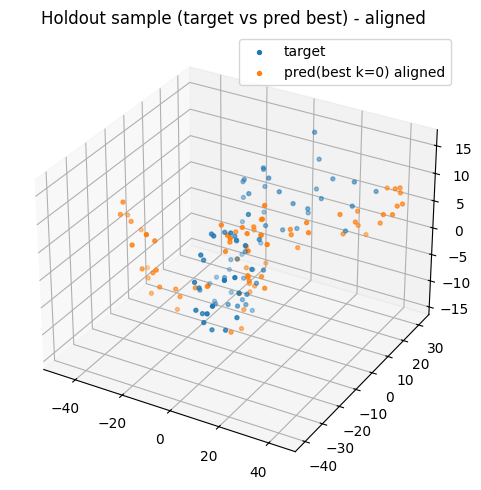

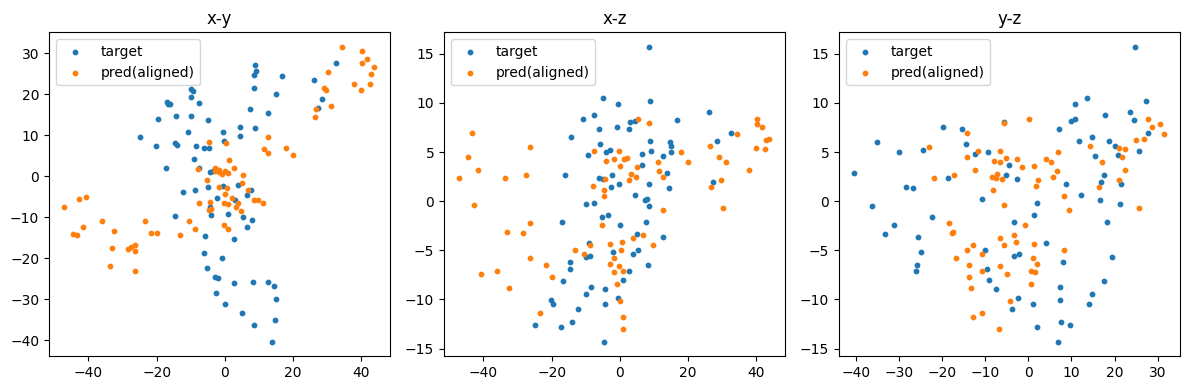

In [11]:
# ==========================================
# 7) Quick sanity check plots (3D + xy/xz/yz)  [v21]
#   - head0가 폭주/붕괴하는지 확인
#   - best head(holdout TM 기준) 시각화
# ==========================================
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

tokens, target, mask = next(iter(hold_loader))
tokens = tokens.to(device); target = target.to(device); mask = mask.to(device)
fb = filter_batch(tokens, target, mask, cfg.min_valid)
if fb is None:
    raise RuntimeError("hold batch has too few valid coords")
tokens, target, mask = fb
pad_mask = (tokens != 0)

model.eval()
with torch.no_grad():
    preds, conf_logits = model(tokens, pad_mask)  # (B,K,T,3)

# metrics per head for sample 0
tm_per_head = []
rmsd_per_head = []
for k in range(cfg.num_preds):
    tm = tm_score_single(preds[0:1, k], target[0:1], mask[0:1])
    rm = kabsch_rmsd_losses(preds[0:1, k:k+1], target[0:1], mask[0:1]).squeeze(0).squeeze(0)
    tm_per_head.append(float(tm.item()))
    rmsd_per_head.append(float(rm.item()))

# --- best-k 선택: (1) TM 최대, (2) 혼합 기준(RMSD + alpha*dist) 최소 ---
best_k_tm = int(np.argmax(tm_per_head))
print("per-head TM:", [round(x,4) for x in tm_per_head], " best_k_tm=", best_k_tm)
print("per-head RMSD:", [round(x,4) for x in rmsd_per_head])

# sampled distance-matrix loss (국소 구조 보존 정도)
dist_bk = pairwise_distance_losses_sampled(preds, target, mask, num_pairs=int(getattr(cfg, "pair_num_pairs", 2048)))
dist_per_head = dist_bk[0].detach().cpu().numpy().tolist()
print("per-head Dist(sampled MSE):", [round(x,4) for x in dist_per_head])

alpha = float(getattr(cfg, "bestk_alpha", 0.30))
mix_score = [r + alpha*d for r, d in zip(rmsd_per_head, dist_per_head)]
best_k_mix = int(np.argmin(mix_score))
print("per-head MixScore(RMSD + alpha*Dist):", [round(x,4) for x in mix_score], f" alpha={alpha}  best_k_mix=", best_k_mix)

# 시각화는 mix 기준(best_k_mix)로 진행 (TM 기준도 비교 가능)
best_k = best_k_mix
# prepare coords
m0 = mask[0].bool()
tgt0 = target[0][m0]
pred_best = preds[0, best_k]
pred_0 = preds[0, 0]

# align both preds to target for fair viz
pred_best_a = kabsch_align(pred_best.unsqueeze(0), target[0].unsqueeze(0), mask[0:1]).squeeze(0)[m0]
pred0_a     = kabsch_align(pred_0.unsqueeze(0),   target[0].unsqueeze(0), mask[0:1]).squeeze(0)[m0]

# simple spread stats (radius of gyration proxy)
def rg(x):
    x = x.float()
    x = x - x.mean(dim=0, keepdim=True)
    return float(torch.sqrt((x*x).sum(dim=1).mean() + 1e-8).item())

print(f"Rg(target)={rg(tgt0):.3f}  Rg(pred_best_aligned)={rg(pred_best_a):.3f}  Rg(pred0_aligned)={rg(pred0_a):.3f}")

# --- 3D plot (best head aligned) ---
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tgt0[:,0].cpu(), tgt0[:,1].cpu(), tgt0[:,2].cpu(), s=8, label="target")
ax.scatter(pred_best_a[:,0].cpu(), pred_best_a[:,1].cpu(), pred_best_a[:,2].cpu(), s=8, label=f"pred(best k={best_k}) aligned")
ax.set_title("Holdout sample (target vs pred best) - aligned")
ax.legend()
plt.tight_layout()
plt.show()

# --- 2D projections ---
A = tgt0
B = pred_best_a

fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[0].scatter(A[:,0].cpu(), A[:,1].cpu(), s=10, label="target")
axes[0].scatter(B[:,0].cpu(), B[:,1].cpu(), s=10, label="pred(aligned)")
axes[0].set_title("x-y"); axes[0].legend()

axes[1].scatter(A[:,0].cpu(), A[:,2].cpu(), s=10, label="target")
axes[1].scatter(B[:,0].cpu(), B[:,2].cpu(), s=10, label="pred(aligned)")
axes[1].set_title("x-z"); axes[1].legend()

axes[2].scatter(A[:,1].cpu(), A[:,2].cpu(), s=10, label="target")
axes[2].scatter(B[:,1].cpu(), B[:,2].cpu(), s=10, label="pred(aligned)")
axes[2].set_title("y-z"); axes[2].legend()

plt.tight_layout()
plt.show()
